In [1]:
import matplotlib_venn

In [4]:
#imports and maths funcs used
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import scipy
from scipy import special
import time
from scipy import stats
#func to find the cosine similarity  vectors a and maxtrix B 
#where B is made up of vectors b1 b2... that are the same dim as a
#shape of B needs to be (a.shape,number of vectors to compare with)
import numpy.linalg as LA
def multi_cos_sim(a,B):
    #first to do some checks to see inputs are the right shape
    B_shape = B.shape 
    if B_shape[0] == len(a):
        numerator = np.dot(a,B)
        B_norm = LA.norm(B, axis=0)
        a_norm = LA.norm(a)
        return (numerator)/(B_norm*a_norm) # dont take abs yet intreased in postive and negative cosine sim
    else:
        print('Error dim of vectors in B, ' + str(B_shape[0]) + ' do not match dim a ' + str(len(a)))
        pass

def main_cos_sim(dataframe): #method to find the cosine similairty between all pairs of sites in a clean phos dataframe   
    simList = []
    i = 0 
    #for loop to apply above method to data
    for c in dataframe.columns:
        #print(i,c)
        v1 = dataframe[c].to_numpy()
        V2 = dataframe.to_numpy() #turns the table to numpy array, taking out lables
        V2 = V2 #turns data in V2 to np.float64 data type, required to use LA.norm func
        cosSim = multi_cos_sim(v1,V2)
        simList.append((cosSim))
        i = i +1
    return simList

In [3]:
def pre_process(file_pathFC,file_pathErrorCS,file_path_pval,fp_drop_sites):
    #inputs data and rearanges it
    raw_data = pd.read_csv(file_pathFC, sep=',') #imports the data into a pandas dataframe
    raw_data = raw_data.T
    raw_data.columns = raw_data.iloc[0]
    raw_data = raw_data.drop(raw_data.index[0])
    data = raw_data
    
    #takes out 'absent' swaps 'down' to -10 'up' to 10 and 'no change' to 0
    #as erf(10) = 1, erf(-10) = -1 and erf(0) = 0
    clean_data = data.replace('absent',np.nan).dropna(axis='columns')
    del_sites = np.loadtxt(fp_drop_sites, delimiter=',',dtype = 'str')
    clean_data = clean_data.drop(del_sites,axis = 1)
    clean_data = clean_data.replace('no_change',np.nan).dropna(axis='columns')
    clean_data = clean_data.replace('down',-10)
    clean_data = clean_data.replace('up',10)
    clean_data = clean_data.astype(float)
    
    squashed_data = special.erf(clean_data)
    #read in the errors/pvals
    CS_errorEfc = pd.read_csv(file_pathErrorCS, sep=',') 
    CS_errorEfc.drop(columns = 'pst',inplace = True)
    CS_errorEfc.index = CS_errorEfc.columns 
    
    raw_pvals = pd.read_csv(file_path_pval, sep=',') #imports the data into a pandas dataframe
    raw_pvals = raw_pvals.T
    raw_pvals.columns = raw_pvals.iloc[0]
    raw_pvals = raw_pvals.drop(raw_pvals.index[0])
    raw_pvals = raw_pvals.replace('absent',np.nan).dropna(axis='columns')
    raw_pvals = raw_pvals.drop(del_sites,axis = 1)
    raw_pvals = raw_pvals.replace('no_change',np.nan).dropna(axis='columns')
    raw_pvals =raw_pvals.astype('float')
    print('should match:')
    print(raw_pvals.shape,clean_data.shape) 
    stdDF = raw_pvals*clean_data
    stdDF_erf = stdDF*np.exp(-clean_data**2)*(2/ (np.pi**0.5) )

    
    return squashed_data,CS_errorEfc,stdDF_erf

def run_CS_anyli(procssed_data):  #DF gives the cos_sim between rows and column, note diag 1 as it compares the same sites
    #procssed_data_copy = procssed_data.copy(deep=True)
    PairSimList = main_cos_sim(procssed_data)  
    CS_data = pd.DataFrame(PairSimList,index = procssed_data.columns, columns= procssed_data.columns)
    np.fill_diagonal(CS_data.values,0) #fills diag with 0 i.e. the sites comapred with themself    
    return CS_data

# MCF7

In [4]:
file_pathFC,file_pathErrorCS = 'ctamdb_data_fcs_MCF7.csv','CS_error_Erf.csv' 
file_path_pval,fp_drop_sites = 'ctamdb_data_pvals_MCF7.csv','MCF7_remove_sites'
squashed_data,CS_errorEfc,stdDF_erf = pre_process(file_pathFC,file_pathErrorCS,file_path_pval,fp_drop_sites)

KeyboardInterrupt: 

In [4]:
CS_dataEfc = run_CS_anyli(squashed_data)

In [5]:
def Find_sim_sitesQNC(CS_data,err_df,threshold):
    cos98temp = CS_data[CS_data - err_df*1.96> threshold].dropna(how = 'all')
    return cos98temp

In [6]:
def Find_sim_sitesQ(CS_data,err_df,threshold):
    cos98temp = CS_data[CS_data - err_df*1.96> threshold].dropna(how = 'all')
    return cos98temp

In [7]:
def total_pairsHCS(CS_data,err_df,Tthreshold):
    FL = []
    for threshold in Tthreshold:
        print(threshold)
        highCorr_dfT = Find_sim_sitesQ(CS_data,err_df,threshold)
        num_pairs = np.sum(np.sum(np.isnan(highCorr_dfT) == False,axis = 1))
        FL.append(num_pairs)
    total_numPairs = np.array(FL)
    return total_numPairs

In [21]:
highCorr_dfT = Find_sim_sitesQ(CS_dataEfc,CS_errorEfc,0.8)

In [31]:
cosSim98_err = find_HC_pairs(highCorr_dfT)

In [39]:
thresh_range = np.arange(0.55,0.96,0.05)
total_numPairs = total_pairsHCS(CS_dataEfc,CS_errorEfc,thresh_range)

0.55
0.6000000000000001
0.6500000000000001
0.7000000000000002
0.7500000000000002
0.8000000000000003
0.8500000000000003
0.9000000000000004
0.9500000000000004


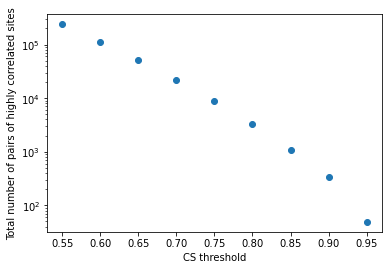

In [42]:
plt.scatter(thresh_range,total_numPairs/2)
plt.xlabel('CS threshold')
plt.ylabel('Total number of pairs of highly correlated sites')
plt.yscale('log')
plt.show()

In [9]:
#method 1 clustering
def cluster_no_duplicates(Correlated_sites,CS_DF,CS_threshold):#clustering only one site can be in one cluster 
    used_site = []
    clust = []
    unique_site = Correlated_sites.index
    # CS_threshold sets threshold for a site to be within a cluster 
    #loop over all unique sites
    i = 0
    for s in unique_site:
        if s in used_site:
            pass
        else:
            clust.append([s] ) #start a cluster with s  
            #consider if the sites that are highly correlated with s will be in the cluster 
            considered_sites = Correlated_sites.loc[s].dropna().index
            CS_DF_subset = CS_DF[clust[i]]
            for s2 in considered_sites:
                s2_clust_CS = CS_DF_subset.loc[s2] #finds the CS between s2 all sites in the cluster under consideration
                #checks if s2 is within the threshold to all other sites currnetly in the cluster
                num_thresh = np.sum(s2_clust_CS > CS_threshold) 
                #if s2 is closer than the threshold to all sites in the cluster under consideration
                #add it to the cluster and remove it from the sites that need to be condiered in the future 
                #also remove it from the correlated_sites list so that its not used again in another cluster 
                if num_thresh == len(s2_clust_CS) and s2 not in used_site:
                    clust[i].append(s2)
                    used_site.append(s2)
                    #CS_DF = CS_DF.drop(s2)
                    #CS_DF = CS_DF.drop(columns = s2)
            i = i + 1 
            used_site.append(s2)
            #CS_DF = CS_DF.drop(s)
            #CS_DF = CS_DF.drop(columns = s)   
    return clust

def cluster_stats(cluster): #finds total number of clusters and av number of sites in each cluster
    length = len(cluster)
    num_sites_eachClust = []
    for sites in cluster:
        num_sites_eachClust.append(len(sites))
    std = np.std(num_sites_eachClust)    
    mean_num_sites = np.mean(num_sites_eachClust)
    return length,mean_num_sites,std,num_sites_eachClust

### Stores the unique clusters in an output file

In [10]:
def store_clust(CS_DF,CSerrorDF, CS_threshold_range):
    for CS_threshold in CS_threshold_range: #loops over the CS threshold 
        Correlated_sites = Find_sim_sitesQ(CS_DF,CSerrorDF,CS_threshold) #finds the highly corralted sites
        clust = cluster_no_duplicates(Correlated_sites,CS_DF,CS_threshold) #finds the unique clusters
        clust = sorted(clust, key = len,reverse=True) #sorts clusters by size from largest to smallets
        #saves clusters as a file 
        f_name = str(np.round(CS_threshold,2)) + 'TCSFinal_unique_clustMCF7.csv'
        np.savetxt(f_name,np.array(clust),fmt='%s')

thresh_range = np.arange(0.55,0.96,0.05)
store_clust(CS_dataEfc,CS_errorEfc,thresh_range)

### Stores the simple clusters in an output file 

In [11]:
#most useful for the prediction alg 
def cluster_CS_simpd(cosSim_DF): #clustering one cluster of each unique highly corelated site
    clust_dic = dict()
    for s in cosSim_DF.index:
        clust = cosSim_DF.loc[s].dropna().index
        clust_dic[s] = list(clust)
    return clust_dic

In [12]:
#most useful for the prediction alg 
def cluster_CS_simp(cosSim_DF): #clustering one cluster of each unique highly corelated site
    clustL = []
    for s in cosSim_DF.index:
        clusTemp = []
        clusTemp.append(s)
        clust = cosSim_DF.loc[s].dropna().index
        clusTemp.extend(clust)
        clustL.append(clusTemp)
    return clustL

In [13]:
def store_simp_clust(CS_DF,CSerrorDF, CS_threshold_range):
    All_simp_clusts = []
    for CS_threshold in CS_threshold_range: #loops over the CS threshold 
        Correlated_sites = Find_sim_sitesQ(CS_DF,CSerrorDF,CS_threshold) #finds the highly corralted sites
        clust = cluster_CS_simp(Correlated_sites) #finds the unique clusters
        #saves clusters as a file 
        f_name = str(np.round(CS_threshold,2)) + 'TCSFinal_simp_clustMCF7.csv'
        All_simp_clusts.append(clust)
        #np.savetxt(f_name,np.array(clust),fmt='%s') #uncomment this to re save the files
    return All_simp_clusts

In [279]:
thresh_range = np.arange(0.55,0.96,0.05)
MCF7_AllSC = store_simp_clust(CS_dataEfc,CS_errorEfc,thresh_range)

In [14]:
def readLLcsv(file_path):
    import csv
    with open(file_path, newline='') as f:
        reader = csv.reader(f)
        data = []
        for rows in reader:
            dataT = []
            for s in rows:
                dataT.append(s[2:len(s) - 1])
            data.append(dataT)
    return data

## Looking at the dff cluster plots

In [15]:
def clust_diffCS(threshold_range,CS_dataEfcG,CS_errorEfcG):
    simpClust_dat = []
    uniqueClustdata = []
    for threshold in threshold_range:
        print(threshold)
        highCorr_df = Find_sim_sitesQ(CS_dataEfcG,CS_errorEfcG,threshold)
        len_simp = len(highCorr_df)#how many clusters for prediction model (method 2)
        num_sites_eachSimpC = (np.sum(np.isnan(highCorr_df) == False,axis = 1)).values
        #unique cust 
        clustUnique = cluster_no_duplicates(highCorr_df,CS_dataEfcG,threshold) 
        length,mean_num_sites,std,num_sites_eachClust = cluster_stats(clustUnique)
        
        #appends data
        #the average number of sites in the simple cluster method
        simpClust_dat.append( (np.mean(np.sum(np.isnan(highCorr_df) == False,axis = 1)),len_simp,num_sites_eachSimpC )) 
        uniqueClustdata.append((length,mean_num_sites,std,num_sites_eachClust))
    simpClust_dat = np.array(simpClust_dat)
    return simpClust_dat,uniqueClustdata

In [81]:
thresh_range = np.arange(0.55,0.96,0.05)
simpClust_length,uniqueClustdata = clust_diffCS(thresh_range,CS_dataEfc,CS_errorEfc) #length,mean_num_sites,std

0.55
0.6000000000000001
0.6500000000000001
0.7000000000000002
0.7500000000000002
0.8000000000000003
0.8500000000000003
0.9000000000000004
0.9500000000000004


C:\Users\Nik\anaconda3\envs\tfGpuEn\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


ModeResult(mode=array([1], dtype=int64), count=array([809]))
19.0
ModeResult(mode=array([1], dtype=int64), count=array([1445]))
4.0
ModeResult(mode=array([1], dtype=int64), count=array([1105]))
2.0
ModeResult(mode=array([1], dtype=int64), count=array([516]))
1.0


C:\Users\Nik\anaconda3\envs\tfGpuEn\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  import sys


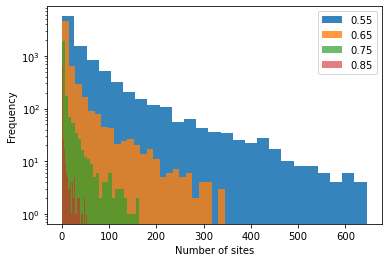

In [124]:
for i in np.arange(0,len(simpClust_length) - 1,2):
    print(stats.mode((simpClust_length[i][2])))
    print(np.median(simpClust_length[i][2]))
    CS_lab = thresh_range
    plt.hist( (np.array(simpClust_length[i][2])),
             alpha = 0.9 - 0.05*i,label = np.round(CS_lab[i],2), bins = 25)  
    plt.yscale('log', nonposy='clip')
    plt.xlabel('Number of sites')
    plt.ylabel('Frequency')
    plt.legend()
plt.show()

ModeResult(mode=array([1]), count=array([1530]))
1.0
ModeResult(mode=array([1]), count=array([1189]))
2.0
ModeResult(mode=array([2]), count=array([553]))
2.0
ModeResult(mode=array([2]), count=array([260]))
2.0


C:\Users\Nik\anaconda3\envs\tfGpuEn\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  import sys


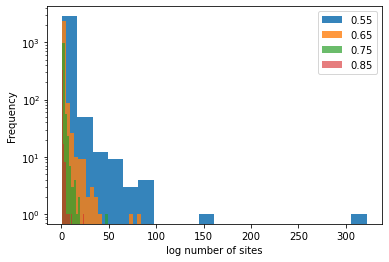

In [117]:
for i in np.arange(0,len(uniqueClustdata) - 1,2):
    print(stats.mode((uniqueClustdata[i][3])))
    print(np.median(uniqueClustdata[i][3]))
    CS_lab = thresh_range
    plt.hist((np.array(uniqueClustdata[i][3])),
             alpha = 0.9 - 0.05*i,label = np.round(CS_lab[i],2), bins = 20)  
    plt.yscale('log', nonposy='clip')

plt.xlabel('log number of sites')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [16]:
def plot_clustR(simpR,uniqueR):
    #plots results from simple cluster 
    plt.scatter(thresh_range,[y1[1] for y1 in simpR]) #plots for simple clusters
    plt.xlabel('CS threshold')
    plt.ylabel('Total number of clusters')
    plt.show()
    plt.scatter(thresh_range,[y1[0] for y1 in simpR]) #plots for simple clusters
    plt.xlabel('CS threshold')
    plt.ylabel('Mean number of sites within the clusters')
    plt.show()
    print('---- unique clust below')
    for i in np.arange(0,len(simpR) - 1,2):
        print(stats.mode((simpR[i][2])))
        print(np.median(simpR[i][2]))
        CS_lab = thresh_range
        plt.hist( (np.array(simpR[i][2])),
                 alpha = 0.9 - 0.05*i,label = np.round(CS_lab[i],2), bins = 25)  
    plt.yscale('log', nonposy='clip')
    plt.xlabel('Number of sites')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    
    
    
    
    #plots for unique cluster (scatter plots)
    plt.scatter(thresh_range,[y[0] for y in uniqueR]) #number of unique clusters
    plt.xlabel('CS threshold')
    plt.ylabel('Total number of clusters')
    plt.show()
    plt.scatter(thresh_range,[y[1] for y in uniqueR]) #mean length the unique clusters
    plt.xlabel('CS threshold')
    plt.ylabel('Mean number of sites within the clusters')
    plt.show()
    
    #plots hist for unique cluster
    for i in np.arange(0,len(uniqueR) - 1,2):
        print(stats.mode((uniqueR[i][3])))
        print(np.median(uniqueR[i][3]))
        CS_lab = thresh_range
        plt.hist((np.array(uniqueR[i][3])),
                 alpha = 0.9 - 0.05*i,label = np.round(CS_lab[i],2), bins = 20)  
        plt.yscale('log', nonposy='clip')

    plt.xlabel('Number of sites')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [10]:
np.random.choice(100, 100,replace=False)

array([73, 22,  1, 25, 77, 87, 53, 37, 93, 54, 47,  8, 64, 60, 32, 88,  9,
       41, 50, 38, 17,  5, 79, 59, 65, 23, 13, 51, 78, 70, 24, 34, 68, 67,
       21, 44, 58, 48, 46, 55, 82, 10, 26, 61, 62, 27, 45, 75, 16, 97, 98,
       31, 83, 52, 30, 19,  7, 14, 35, 29, 36, 28, 94, 42, 95, 69, 89, 66,
       85,  0, 96, 57, 86, 84, 80,  6, 56, 92, 63, 40, 90, 71, 12, 18, 76,
       49, 39, 74,  4, 20, 33,  2, 81, 99, 15, 91, 43,  3, 72, 11])

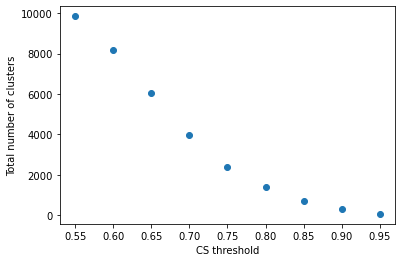

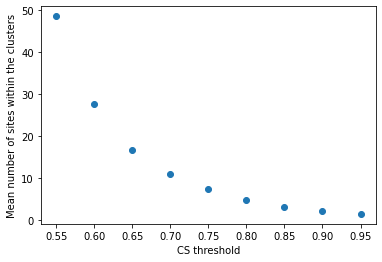

---- unique clust below
ModeResult(mode=array([1], dtype=int64), count=array([809]))
19.0
ModeResult(mode=array([1], dtype=int64), count=array([1445]))
4.0
ModeResult(mode=array([1], dtype=int64), count=array([1105]))
2.0
ModeResult(mode=array([1], dtype=int64), count=array([516]))
1.0


C:\Users\Nik\anaconda3\envs\tfGpuEn\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


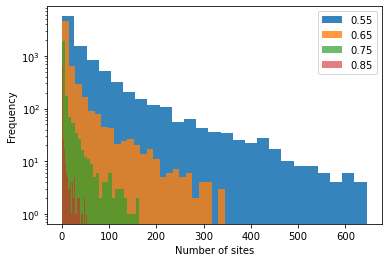

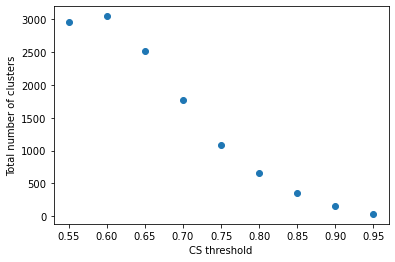

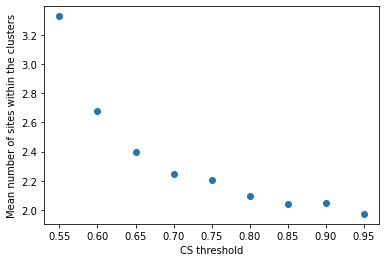

ModeResult(mode=array([1]), count=array([1530]))
1.0
ModeResult(mode=array([1]), count=array([1189]))
2.0
ModeResult(mode=array([2]), count=array([553]))
2.0
ModeResult(mode=array([2]), count=array([260]))
2.0


C:\Users\Nik\anaconda3\envs\tfGpuEn\lib\site-packages\ipykernel_launcher.py:45: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


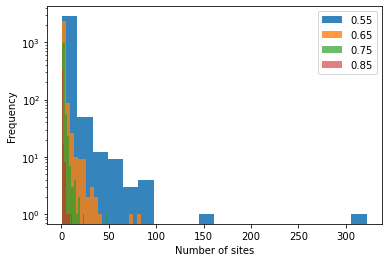

In [131]:
plot_clustR(simpClust_length,uniqueClustdata)

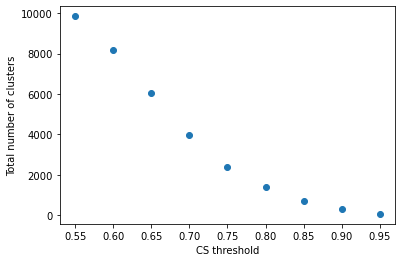

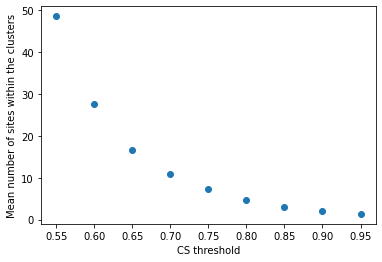

In [415]:
plt.scatter(thresh_range,[y1[1] for y1 in simpClust_length]) #plots for simple clusters
plt.xlabel('CS threshold')
plt.ylabel('Total number of clusters')
plt.show()
plt.scatter(thresh_range,[y1[0] for y1 in simpClust_length]) #plots for simple clusters
plt.xlabel('CS threshold')
plt.ylabel('Mean number of sites within the clusters')
plt.show()

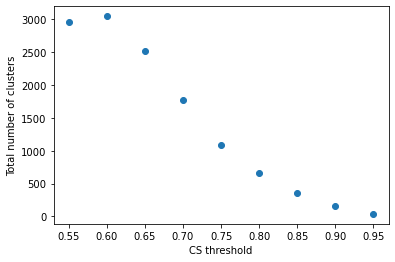

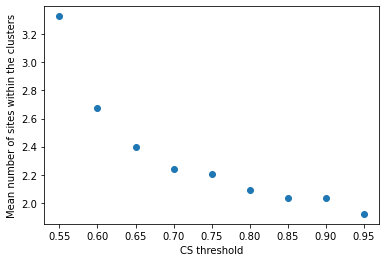

In [442]:
#plots for unique cluster 
plt.scatter(thresh_range,[y[0] for y in uniqueClustdata]) #number of unique clusters
plt.xlabel('CS threshold')
plt.ylabel('Total number of clusters')
plt.show()
plt.scatter(thresh_range,[y[1] for y in uniqueClustdata]) #mean length the unique clusters
plt.xlabel('CS threshold')
plt.ylabel('Mean number of sites within the clusters')
plt.show()

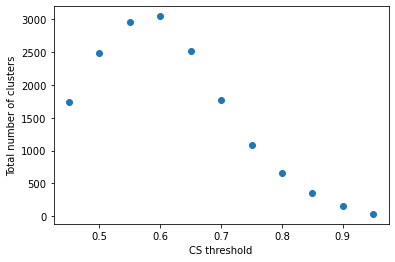

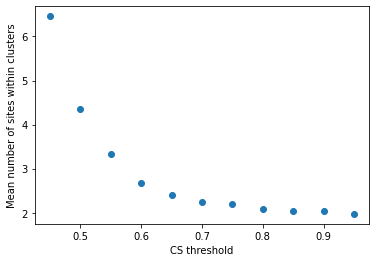

In [227]:
#plots for unique cluster old plots with bigger cs thrus range
plt.scatter(thresh_range,[y[0] for y in uniqueClustdata]) #number of unique clusters
plt.xlabel('CS threshold')
plt.ylabel('Total number of clusters')
plt.show()
plt.scatter(thresh_range,[y[1] for y in uniqueClustdata]) #mean length the unique clusters
plt.xlabel('CS threshold')
plt.ylabel('Mean number of sites within the clusters')
plt.show()

ModeResult(mode=array([1]), count=array([1530]))
1.0
0.55
ModeResult(mode=array([1]), count=array([1190]))
2.0
0.55
ModeResult(mode=array([2]), count=array([553]))
2.0
0.55
ModeResult(mode=array([2]), count=array([260]))
2.0
0.55


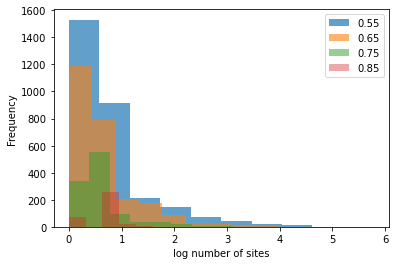

In [459]:
from scipy import stats
for i in np.arange(0,len(uniqueClustdata) - 1,2):
    print(stats.mode((uniqueClustdata[i][3])))
    print(np.median(uniqueClustdata[i][3]))
    print(alph)
    CS_lab = thresh_range
    plt.hist( np.log(np.array(uniqueClustdata[i][3])),alpha = 0.7 - 0.05*i,label = np.round(CS_lab[i],2), bins = 10)  
    
plt.xlabel('log number of sites')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Mote carlo sim
sim to decide the lower bound of the CS cut  off to use

In [420]:
rand_data = pd.DataFrame(np.random.uniform(low=-1, high=1, size=(61,8000)))
CS_rand_data = run_CS_anyli(rand_data)

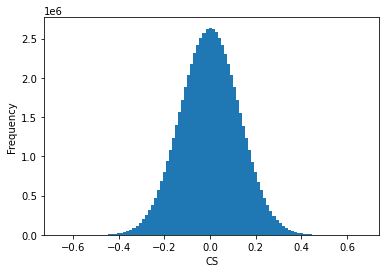

In [421]:
plt.hist(CS_rand_data.values.flatten(),bins = 100)
plt.ylabel('Frequency')
plt.xlabel('CS')
plt.show()

In [ ]:
stats.norm.fit(CS_rand_data.values.flatten())

In [435]:
0.12803246418996692*4.286123198984807
CS = 0.7
cv = CS/0.12803246418996692
cv

5.467363331860752

In [334]:
8000*8000

64000000

In [335]:
1/64000000

1.5625e-08

In [337]:
scipy.stats.norm.ppf(1/64000000)

-5.534285275739051

In [440]:
scipy.stats.norm.ppf(1/4e7)

-5.451310437845478

In [441]:
64000000/4e7

1.6

# Other cell lines
## HL60

In [11]:
file_pathFC,file_pathErrorCS = 'Other_cellLines/ctamdb_data_fcs_HL60.csv','Other_cellLines/CS_error_Erf_ML60.csv' 
file_path_pval,fp_drop_sites = 'Other_cellLines/ctamdb_data_pvals_HL60.csv','Other_cellLines/ML60_remove_sites'
squashed_dataHL60,CS_errorEfcHL60,stdDF_erfHL60 = pre_process(file_pathFC,file_pathErrorCS,
                                                          file_path_pval,fp_drop_sites)

should match:
(61, 11143) (61, 11143)


In [12]:
CS_dataEfcHL60 = run_CS_anyli(squashed_dataHL60)
#threshold = 0.95
#highCorr_df = Find_sim_sitesQ(CS_dataEfcHL60,CS_errorEfcHL60,threshold)

In [489]:
CS_dataEfcHL60

pst,AAAS(S495),AAK1(S14),AAK1(S21),AAK1(S637),AAK1(S678),AAK1(T389),AAK1(T606),AAK1(T653),AATF(S203),AATF(S316),...,ZYX(S267),ZYX(S281),ZYX(S308),ZYX(S344),ZYX(T270),ZYX(T274),ZZEF1(S1464),ZZEF1(S1518),ZZZ3(S113),ZZZ3(S82)
pst,,,,,,,,,,,,,,,,,,,,,
AAAS(S495),0.000000,0.131280,0.097145,0.348516,-0.156216,0.350942,0.281558,0.103999,-0.258395,-0.457952,...,0.289849,0.285790,0.511182,0.418938,-0.123006,0.045448,-0.027130,0.205300,0.073252,0.407705
AAK1(S14),0.131280,0.000000,-0.199936,-0.259297,-0.120833,-0.219312,0.381763,-0.323165,0.184586,0.101068,...,0.094136,-0.132124,0.154179,-0.044886,-0.042073,-0.304648,0.305760,0.202561,-0.095738,-0.173297
AAK1(S21),0.097145,-0.199936,0.000000,0.053190,-0.002030,0.196702,-0.060411,-0.008081,-0.183545,-0.002653,...,0.151609,0.113263,0.030268,0.122212,0.005564,0.094468,-0.369345,0.112362,0.128125,0.221460
AAK1(S637),0.348516,-0.259297,0.053190,0.000000,-0.016807,0.451940,-0.071865,0.499551,-0.052975,-0.483689,...,-0.092069,0.118942,0.068128,0.319369,-0.018458,0.458683,-0.205316,-0.232508,0.037530,0.203077
AAK1(S678),-0.156216,-0.120833,-0.002030,-0.016807,0.000000,-0.074024,-0.084252,-0.021112,0.071826,-0.224381,...,0.046168,-0.175846,-0.115236,0.184346,-0.134456,-0.004761,-0.033615,-0.099598,0.171661,-0.220122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYX(T274),0.045448,-0.304648,0.094468,0.458683,-0.004761,0.369889,-0.080682,0.375406,0.227851,-0.510978,...,-0.180959,0.155202,-0.099067,0.326004,0.049391,0.000000,-0.375859,-0.089060,0.255441,0.238799
ZZEF1(S1464),-0.027130,0.305760,-0.369345,-0.205316,-0.033615,-0.395928,0.244476,-0.056936,0.064527,0.243675,...,0.061922,-0.056635,-0.010793,-0.166219,0.017331,-0.375859,0.000000,0.208523,-0.222321,-0.227339
ZZEF1(S1518),0.205300,0.202561,0.112362,-0.232508,-0.099598,-0.201137,0.363836,-0.151956,0.230574,-0.069199,...,0.137184,-0.015398,0.095216,-0.045048,-0.283767,-0.089060,0.208523,0.000000,0.089703,0.225364


In [483]:
thresh_range = np.arange(0.55,0.96,0.05) 
#clust_diffCS(threshold_range,CS_dataEfcG,CS_errorEfcG)
simpClust_lengthHL60,uniqueClustdataHL60 = clust_diffCS(thresh_range,CS_dataEfcHL60
                                                        ,CS_errorEfcHL60) #length,mean_num_sites,std

0.55
0.6000000000000001
0.6500000000000001
0.7000000000000002
0.7500000000000002
0.8000000000000003
0.8500000000000003
0.9000000000000004
0.9500000000000004


0.55
0.6000000000000001
0.6500000000000001
0.7000000000000002
0.7500000000000002
0.8000000000000003
0.8500000000000003
0.9000000000000004
0.9500000000000004


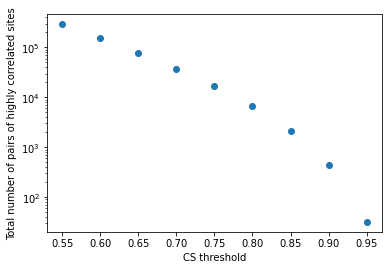

array([2.91486e+05, 1.51479e+05, 7.63900e+04, 3.70290e+04, 1.66190e+04,
       6.59800e+03, 2.10400e+03, 4.40000e+02, 3.20000e+01])

In [45]:
total_numPairs = total_pairsHCS(CS_dataEfcHL60,CS_errorEfcHL60,thresh_range)
plt.scatter(thresh_range,total_numPairs/2)
plt.xlabel('CS threshold')
plt.ylabel('Total number of pairs of highly correlated sites')
plt.yscale('log')
plt.show()
total_numPairs/2

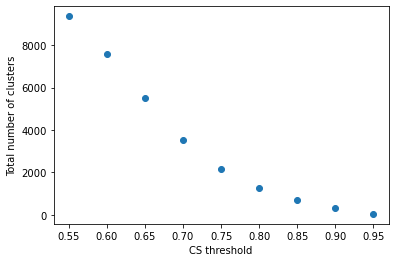

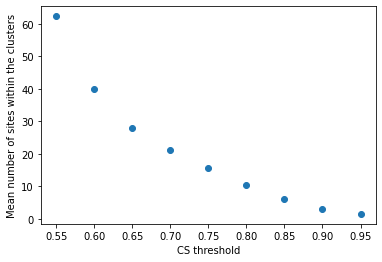

---- unique clust below


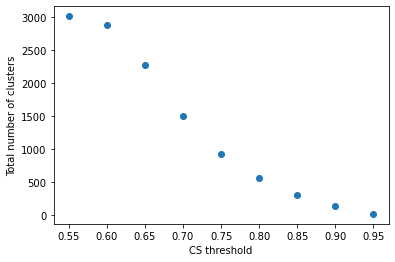

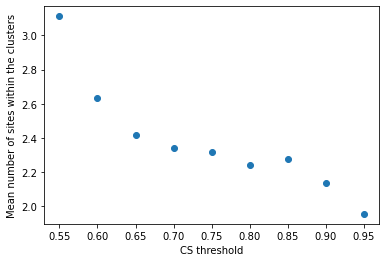

ModeResult(mode=array([1]), count=array([1530]))
1.0
ModeResult(mode=array([1]), count=array([1190]))
2.0
ModeResult(mode=array([2]), count=array([553]))
2.0
ModeResult(mode=array([2]), count=array([260]))
2.0


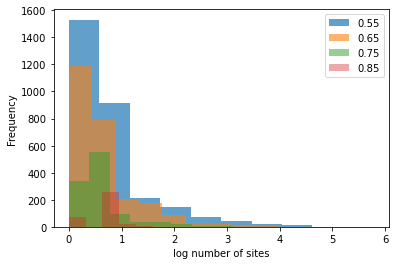

In [485]:
plot_clustR(simpClust_lengthHL60,uniqueClustdataHL60)

In [490]:
CS_dataEfcHL60

pst,AAAS(S495),AAK1(S14),AAK1(S21),AAK1(S637),AAK1(S678),AAK1(T389),AAK1(T606),AAK1(T653),AATF(S203),AATF(S316),...,ZYX(S267),ZYX(S281),ZYX(S308),ZYX(S344),ZYX(T270),ZYX(T274),ZZEF1(S1464),ZZEF1(S1518),ZZZ3(S113),ZZZ3(S82)
pst,,,,,,,,,,,,,,,,,,,,,
AAAS(S495),0.000000,0.131280,0.097145,0.348516,-0.156216,0.350942,0.281558,0.103999,-0.258395,-0.457952,...,0.289849,0.285790,0.511182,0.418938,-0.123006,0.045448,-0.027130,0.205300,0.073252,0.407705
AAK1(S14),0.131280,0.000000,-0.199936,-0.259297,-0.120833,-0.219312,0.381763,-0.323165,0.184586,0.101068,...,0.094136,-0.132124,0.154179,-0.044886,-0.042073,-0.304648,0.305760,0.202561,-0.095738,-0.173297
AAK1(S21),0.097145,-0.199936,0.000000,0.053190,-0.002030,0.196702,-0.060411,-0.008081,-0.183545,-0.002653,...,0.151609,0.113263,0.030268,0.122212,0.005564,0.094468,-0.369345,0.112362,0.128125,0.221460
AAK1(S637),0.348516,-0.259297,0.053190,0.000000,-0.016807,0.451940,-0.071865,0.499551,-0.052975,-0.483689,...,-0.092069,0.118942,0.068128,0.319369,-0.018458,0.458683,-0.205316,-0.232508,0.037530,0.203077
AAK1(S678),-0.156216,-0.120833,-0.002030,-0.016807,0.000000,-0.074024,-0.084252,-0.021112,0.071826,-0.224381,...,0.046168,-0.175846,-0.115236,0.184346,-0.134456,-0.004761,-0.033615,-0.099598,0.171661,-0.220122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYX(T274),0.045448,-0.304648,0.094468,0.458683,-0.004761,0.369889,-0.080682,0.375406,0.227851,-0.510978,...,-0.180959,0.155202,-0.099067,0.326004,0.049391,0.000000,-0.375859,-0.089060,0.255441,0.238799
ZZEF1(S1464),-0.027130,0.305760,-0.369345,-0.205316,-0.033615,-0.395928,0.244476,-0.056936,0.064527,0.243675,...,0.061922,-0.056635,-0.010793,-0.166219,0.017331,-0.375859,0.000000,0.208523,-0.222321,-0.227339
ZZEF1(S1518),0.205300,0.202561,0.112362,-0.232508,-0.099598,-0.201137,0.363836,-0.151956,0.230574,-0.069199,...,0.137184,-0.015398,0.095216,-0.045048,-0.283767,-0.089060,0.208523,0.000000,0.089703,0.225364


In [494]:
CS_dataEfcHL60.columns[0:1]

Index(['AAAS(S495)'], dtype='object', name='pst')

cos98temp = CS_dataEfcHL60
#taking the NaNs out of the above list and pairing the correlated sites with each other
FL = []
mp = 0 
for i,r in cos98temp.iterrows():
    print(mp)
    #print('****')
    #print(r.dropna())
    for ind,val in zip(r.index[0:mp],r[0:mp]):
        FL.append( (i,ind,val) )
    mp = mp + 1 
cosSim98_err = pd.DataFrame(FL)
cosSim98_err

cosSim98_err.to_csv('Full_pairs_CS_HL60_err.csv') 

In [289]:
thresh_range = np.arange(0.55,0.96,0.05)
HL60_AllSC = store_simp_clust(CS_dataEfcHL60,CS_errorEfcHL60,thresh_range)

## NTERA2

In [14]:
file_pathFC,file_pathErrorCS = 'Other_cellLines/ctamdb_data_fcs_NTERA2.csv','Other_cellLines/CS_error_Erf_NTERA2.csv' 
file_path_pval,fp_drop_sites = 'Other_cellLines/ctamdb_data_pvals_NTERA2.csv','Other_cellLines/NTERA2_remove_sites'
squashed_dataNTERA2,CS_errorEfcNTERA2,stdDF_erfNTERA2 = pre_process(file_pathFC,file_pathErrorCS,
                                                          file_path_pval,fp_drop_sites)

should match:
(61, 11445) (61, 11445)


In [15]:
CS_dataEfcNTERA2 = run_CS_anyli(squashed_dataNTERA2)

0.55
0.6000000000000001
0.6500000000000001
0.7000000000000002
0.7500000000000002
0.8000000000000003
0.8500000000000003
0.9000000000000004
0.9500000000000004


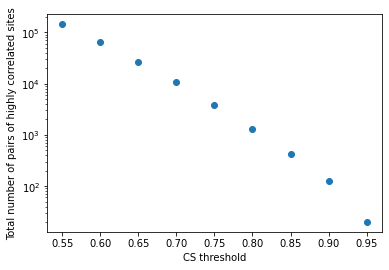

array([1.44893e+05, 6.39930e+04, 2.69990e+04, 1.06300e+04, 3.86700e+03,
       1.31200e+03, 4.29000e+02, 1.28000e+02, 2.00000e+01])

In [46]:
total_numPairs = total_pairsHCS(CS_dataEfcNTERA2,CS_errorEfcNTERA2,thresh_range)
plt.scatter(thresh_range,total_numPairs/2)
plt.xlabel('CS threshold')
plt.ylabel('Total number of pairs of highly correlated sites')
plt.yscale('log')
plt.show()
total_numPairs/2

0.55
0.6000000000000001
0.6500000000000001
0.7000000000000002
0.7500000000000002
0.8000000000000003
0.8500000000000003
0.9000000000000004
0.9500000000000004


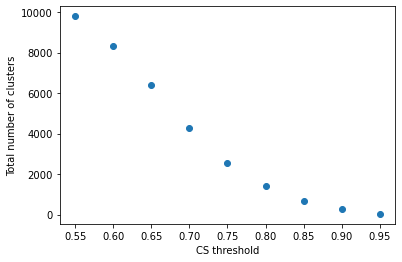

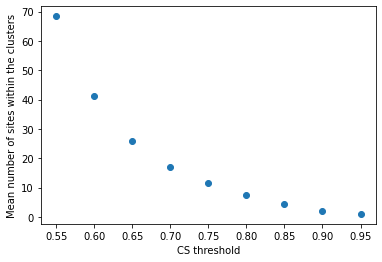

---- unique clust below


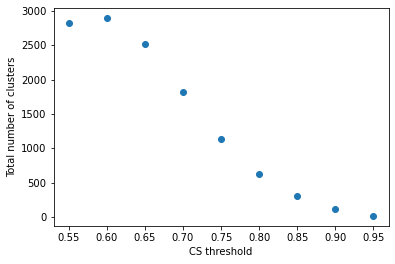

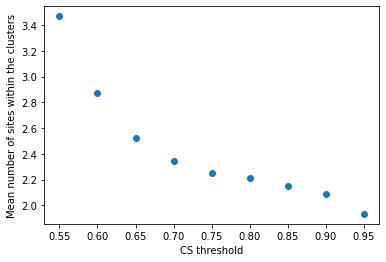

ModeResult(mode=array([1]), count=array([1530]))
1.0
ModeResult(mode=array([1]), count=array([1190]))
2.0
ModeResult(mode=array([2]), count=array([553]))
2.0
ModeResult(mode=array([2]), count=array([260]))
2.0


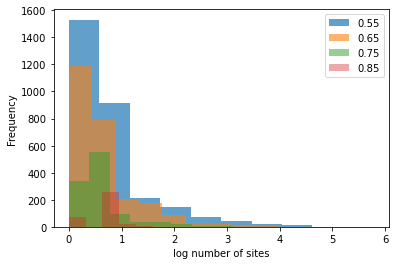

In [487]:
CS_dataEfcNTERA2 = run_CS_anyli(squashed_dataHL60)
thresh_range = np.arange(0.55,0.96,0.05) 
#clust_diffCS(threshold_range,CS_dataEfcG,CS_errorEfcG)
simpClust_lengthNTERA2,uniqueClustdataNTERA2 = clust_diffCS(thresh_range,CS_dataEfcNTERA2
                                                        ,CS_errorEfcNTERA2) #length,mean_num_sites,std
plot_clustR(simpClust_lengthNTERA2,uniqueClustdataNTERA2)

In [510]:
cos98temp = CS_dataEfcNTERA2
#taking the NaNs out of the above list and pairing the correlated sites with each other
FL = []
mp = 0 
for i,r in cos98temp.iterrows():
    print(mp)
    #print('****')
    #print(r.dropna())
    for ind,val in zip(r.index[0:mp],r[0:mp]):
        FL.append( (i,ind,val) )
    mp = mp + 1 
cosSim98_err = pd.DataFrame(FL)
cosSim98_err

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064


3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726


5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375


6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022


8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673


10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269
10270
10271
10272
10273
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
1028

,0,1,2
0,AAK1(S14),AAAS(S495),0.131280
1,AAK1(S21),AAAS(S495),0.097145
2,AAK1(S21),AAK1(S14),-0.199936
3,AAK1(S637),AAAS(S495),0.348516
4,AAK1(S637),AAK1(S14),-0.259297
...,...,...,...
62077648,ZZZ3(S82),ZYX(T270),-0.247641
62077649,ZZZ3(S82),ZYX(T274),0.238799
62077650,ZZZ3(S82),ZZEF1(S1464),-0.227339
62077651,ZZZ3(S82),ZZEF1(S1518),0.225364


cosSim98_err.to_csv('Full_pairs_CS_NTERA2_err.csv') 

## Compare the highly corrlated sites for each cell line


In [294]:
Tthreshold = [0.55,0.75,0.95]

array([0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [30]:
def find_HC_pairs(CS_DF):
    cos98temp = CS_DF
    #taking the NaNs out of the above list and pairing the correlated sites with each other
    #we want duplicates for the following application. 
    FL = []
    for i,r in cos98temp.iterrows():
        r = r.dropna()
        for ind in r.index:
            FL.append( (i,ind) )
    cosSim98_err = pd.DataFrame(FL)
    return cosSim98_err

In [35]:
def findHC_pairs(CS_data,err_df,Tthreshold):
    HC_pairsL = []
    for threshold in Tthreshold:
        print(threshold)
        highCorr_dfT = Find_sim_sitesQ(CS_data,err_df,threshold)
        HC_pairs = find_HC_pairs(highCorr_dfT)
        HC_pairsL.append(HC_pairs)
    return HC_pairsL 

In [36]:
Tthreshold = [0.8]
HC_pairsMCF7 = findHC_pairs(CS_dataEfc,CS_errorEfc,Tthreshold)
HC_pairsHL60 = findHC_pairs(CS_dataEfcHL60,CS_errorEfcHL60,Tthreshold)

0.8
0.8


In [54]:
HC_pairsNTERA2 = findHC_pairs(CS_dataEfcNTERA2,CS_errorEfcNTERA2,Tthreshold)

0.8


### HL60/TER Venn

In [44]:
511/ ( 35523+511 + 347 + 674)

0.01379031169882607

In [45]:
99/ ( 6288+99 + 96+115)

0.015004546832373447

In [46]:
21/ ( 379+21 + 18+22)

0.04772727272727273

### MCF7/TER venn

In [40]:
767/(767 + 19784 + 647 + 347)

0.035599907171037365

In [41]:
154/(2904+153+115+96)

0.047123623011015914

In [42]:
24/(24+269+18+22)

0.07207207207207207

### NTERA/MCF venn

In [37]:
767/(9000 + 767 + 347 + 511)

0.07218823529411765

In [38]:
154/(964+153+99+96)

0.1173780487804878

In [39]:
24/(24+65+18+21)

0.1875

In [58]:
len(HC_pairsNTERA2[0])/2

1312.0

In [59]:
len(CSLstTERAM_MC[CSLstTERAM_MC > 0.8])/2

209.0

In [61]:
len(CSLst[CSLst > 0.8])/2

271.0

### plotting venn

In [62]:
Tthreshold = [0.70,0.80,0.90]
HC_pairsMCF7 = findHC_pairs(CS_dataEfc,CS_errorEfc,Tthreshold)
HC_pairsHL60 = findHC_pairs(CS_dataEfcHL60,CS_errorEfcHL60,Tthreshold)

0.7
0.8
0.9
0.7
0.8
0.9


In [63]:
HC_pairsNTERA2 = findHC_pairs(CS_dataEfcNTERA2,CS_errorEfcNTERA2,Tthreshold)

0.7
0.8
0.9


In [64]:
def find_shared_sites(new_corrDF,old_corrDF):   
    #finds a 'transpose' df as order of pairs of sites do not matter 

    shared_paris = 0
    for i in range(0,len(new_corrDF)):
        new_row = new_corrDF.iloc[i]
        compare = old_corrDF[new_row == old_corrDF].dropna().values
        if len(compare) > 0:
            shared_paris = shared_paris + len(compare)
            #print(compare,len(compare))
            #print('----')
    return shared_paris/2 #need to devided by two as duplicates in each DF!


In [82]:
def share_trip(DF1,DF2,DF3):
    shared_paris = 0
    for i in range(0,len(DF2)):
        new_row = DF2.iloc[i]
        #checks if new_row is in DF1
        compare1 = DF1[new_row == DF1].dropna().values
        #checks if new_row is in DF3
        if len(compare1) > 0:
            compare2 = DF3[DF3 == compare1].dropna().values
            if len(compare2) > 0:
                shared_paris = shared_paris + len(compare2)
                #print(compare,len(compare))
                #print('----')
    return shared_paris/2 #need to devided by two as duplicates in each DF!

In [83]:
trip_shareNum = []
for i in range(0,len(HC_pairsHL60)):
    trip_shareNum.append(share_trip(HC_pairsHL60[i],HC_pairsNTERA2[i],HC_pairsMCF7[i]))

In [84]:
trip_shareNum

[347.0, 96.0, 18.0]

In [65]:
def shared_cs_range(DF1List,DF2List): 
    shared = []
    i = 0
    for DF1,DF2 in zip(DF1List,DF2List):
        print(i)
        shared.append(find_shared_sites(DF1,DF2))
        i = i + 1
    return shared

In [66]:
shared_HC60_MCF7 = shared_cs_range(HC_pairsMCF7,HC_pairsHL60)
shared_HC60_MCF7

0
1
2


[821.0, 163.0, 31.0]

In [67]:
shared_HL60_NTERA2 = shared_cs_range(HC_pairsHL60,HC_pairsNTERA2)
shared_MCF7_NTERA2 = shared_cs_range(HC_pairsMCF7,HC_pairsNTERA2)

0
1
2
0
1
2


In [70]:
len(HC_pairsHL60[2]),len(HC_pairsNTERA2[2])

(880, 256)

In [85]:
trip_shareNum

[347.0, 96.0, 18.0]

In [30]:
shared_HC60_MCF7 =[821.0, 163.0, 31.0]
shared_HL60_NTERA2 = [685.0, 147.0, 30.0]
shared_MCF7_NTERA2 = [941.0, 201.0, 33.0]
trip_shareNum = [347.0, 96.0, 18.0]

In [86]:
shared_HC60_MCF7,shared_HL60_NTERA2,shared_MCF7_NTERA2,

([821.0, 163.0, 31.0], [685.0, 147.0, 30.0], [941.0, 201.0, 33.0])

In [24]:
JustMCF7 = [21546.0 - (shared_HC60_MCF[0] + shared_MCF7_NTERA2[0]), 3268.0 - (shared_HC60_MCF[1] + shared_MCF7_NTERA2[1]),
            333.0 - (shared_HC60_MCF[2] + shared_MCF7_NTERA2[2])]

JustNTERA2 = [10630.0 - (shared_HL60_NTERA2[0] + shared_MCF7_NTERA2[0]), 1312.0 - (shared_HL60_NTERA2[1] + shared_MCF7_NTERA2[1]),
            128.0 - (shared_HL60_NTERA2[2] + shared_MCF7_NTERA2[2])]

JustHL60 = [37029.0 - (shared_HL60_NTERA2[0] + shared_HC60_MCF[0]), 6598.0 - (shared_HL60_NTERA2[1] + shared_HC60_MCF[1]),
            440.0 - (shared_HL60_NTERA2[2] + shared_HC60_MCF[2])]

In [32]:
JustMCF7

[19784.0, 2904.0, 269.0]

In [92]:
for i in range(len(HC_pairsMCF7)):
    print( len(HC_pairsMCF7[i])/2)
for i in range(len(HC_pairsMCF7)):
    print(len(HC_pairsNTERA2[i])/2)
for i in range(len(HC_pairsMCF7)):
    print(len(HC_pairsHL60[i])/2)

21546.0
3268.0
333.0
10630.0
1312.0
128.0
37029.0
6598.0
440.0


0.7


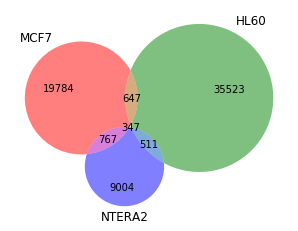

0.8


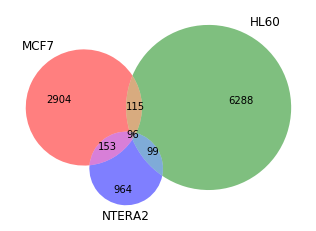

0.9


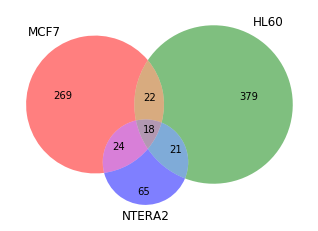

In [34]:
Tthreshold = [0.7,0.8,0.9]
for i in range(3) :
    print(Tthreshold[i])
    matplotlib_venn.venn3(subsets = (int(JustMCF7[i]), int(JustHL60[i]), int(shared_HC60_MCF7[i] - trip_shareNum[i]/2), 
                                     int(JustNTERA2[i]), int(shared_MCF7_NTERA2[i] - trip_shareNum[i]/2), 
                                     int(shared_HL60_NTERA2[i] - trip_shareNum[i]/2), 
                                     int(trip_shareNum[i]) ), set_labels = ('MCF7', 'HL60', 'NTERA2'), alpha = 0.5)
    plt.show()